# NLP CW Task 1

  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks
  - Your .README file should explain how to replicate the different experiments mentioned in your report

In [3]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split
from collections import Counter
import nltk
import string
import torchtext
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from scipy.spatial.distance import euclidean, cosine
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
import codecs
from tqdm import tqdm
import torch.nn.functional as F
import re
import spacy

In [ ]:
# Get pretrained GloVe embeddings
glove = torchtext.vocab.GloVe(name='6B', dim=50)

In [4]:
# Install packages that Colab does not provide automatically
!pip -q install transformers
from transformers import RobertaTokenizer, RobertaModel, BertPreTrainedModel, DistilBertModel, DistilBertTokenizer

# Download stopwords
nltk.download('stopwords')

# Get test and train data files
if not os.path.exists('dev.csv'):
  !wget -q --show-progress https://raw.githubusercontent.com/matt-malarkey/nlp-cw-data/master/dev.csv
  !wget -q --show-progress https://raw.githubusercontent.com/matt-malarkey/nlp-cw-data/master/train.csv

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
dev.csv             100%[===================>] 211.85K  --.-KB/s    in 0.03s   
train.csv           100%[===================>] 925.70K  --.-KB/s    in 0.07s   


In [3]:
# Setting random seed and device
SEED = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('dev.csv')

In [5]:
# Number of epochs
epochs = 10

# Proportion of training data for train compared to dev
train_proportion = 0.8

In [6]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch, optimizer):
  """
  Training loop for the model, which calls on eval to evaluate after each epoch
  """

  print("Training model.")

  loss_fn = nn.MSELoss()
  loss_fn = loss_fn.to(device)

  performance_stats = []

  for epoch in range(1, number_epoch+1):
    model.train()

    epoch_loss = 0
    epoch_sse = 0
    no_observations = 0  # Observations used for training so far

    for batch in train_iter:
      ids = batch['ids'].to(device).squeeze()
      mask = batch['mask'].to(device).squeeze()
      target = batch['target'].to(device, dtype=torch.float)
      extra_features = batch['extra_features'].to(device)

      predictions = model(ids, mask, extra_features).squeeze(1)
      optimizer.zero_grad()
      loss = loss_fn(predictions, target)

      no_observations = no_observations + target.shape[0]
      sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()*target.shape[0]
      epoch_sse += sse

    valid_loss, valid_mse, __, __ = eval(dev_iter, model)

    epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
    performance_stats.append((valid_loss, valid_mse**0.5))
    print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
    Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')

  return performance_stats

In [7]:
# We evaluate performance on our dev set
def eval(data_iter, model):
  """
  Evaluating model performance on the dev set
  """
  model.eval()
  epoch_loss = 0
  epoch_sse = 0
  pred_all = []
  trg_all = []
  no_observations = 0
  loss_fn = nn.MSELoss()
  loss_fn = loss_fn.to(device)

  with torch.no_grad():
    for batch in data_iter:
      ids = batch['ids'].to(device).squeeze()
      mask = batch['mask'].to(device).squeeze()
      target = batch['target'].to(device, dtype=torch.float)
      extra_features = batch['extra_features'].to(device)

      predictions = model(ids, mask, extra_features).squeeze(1)

      loss = loss_fn(predictions, target)

      # We get the mse
      pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
      sse, __ = model_performance(pred, trg)

      no_observations = no_observations + target.shape[0]
      epoch_loss += loss.item()*target.shape[0]
      epoch_sse += sse
      pred_all.extend(pred)
      trg_all.extend(trg)

  return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [8]:
# How we print the model performance
def model_performance(output, target, print_output=False):
  """
  Returns SSE and MSE per batch (printing the MSE and the RMSE)
  """
  sq_error = (output - target)**2

  sse = np.sum(sq_error)
  mse = np.mean(sq_error)
  rmse = np.sqrt(mse)

  if print_output:
    print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

  return sse, mse

# Data Analysis


In [9]:
# Basic Stats
num_headlines = len(train_df)
max_len = max(train_df['original'].apply(len))
avg_score = train_df['meanGrade'].mean()
print(f'Number of Headlines: {num_headlines}, Max Headline Length: {max_len}, Avg Score: {avg_score:.2f}')

# Most common words
stopwords = nltk.corpus.stopwords.words('english')
most_common_words = Counter(" ".join(train_df['original']).split()).most_common(100)
stopwords.append(string.punctuation)
most_common_words = [(word, count) for (word, count) in most_common_words if word not in stopwords and word.isalpha()][:5]
print(f'Most common words: {most_common_words}')

# Analysis of Trump Headlines
trump_headlines = train_df[train_df['original'].str.lower().str.contains('trump')]
num_headlines_with_trump = len(trump_headlines)
trump_avg_score = trump_headlines['meanGrade'].mean()
prob_headline_contains_trump = num_headlines_with_trump / num_headlines
trump_value_counts = trump_headlines['meanGrade'].value_counts(bins=3)
trump_proportion_gt_one = (trump_value_counts[2] + trump_value_counts[3]) * 100 / num_headlines_with_trump
print(f'Headlines with Trump: {prob_headline_contains_trump * 100:.2f}%, Avg Score: {trump_avg_score:.2f}')
print(f'Proportion of Trump Headlines with score > 1: {trump_proportion_gt_one:.2f}%')

# Analysis of word similarity and length of headlines
semantic_similarity_data = []
sentence_similarity_data = []
levenshtein_similarity_data = []
headline_length_data = []

for row in train_df.itertuples():
  all_words = row.original.split(' ')
  headline_length_data.append((len(all_words), row.meanGrade))
  sentence_vec = torch.zeros((1,50))
  for i, word in enumerate(all_words):
    if len(word) > 2 and word[0] == '<' and word[-2] == '/' and word[-1] == '>' :
      word = word[1:-2].lower()
      original_word_vec = glove[word].unsqueeze(0)
      edited_word_vec = glove[row.edit.lower()].unsqueeze(0)
      semantic_distance = torch.cosine_similarity(original_word_vec, edited_word_vec).item() 
      levenshtein_distance = nltk.edit_distance(word, row.edit.lower())
      semantic_similarity_data.append((semantic_distance, row.meanGrade))
      levenshtein_similarity_data.append((levenshtein_distance, row.meanGrade))
    else:
      sentence_vec += glove[word.lower()].unsqueeze(0)
    
    if i == len(all_words) - 1:
      sentence_semantic_distance = torch.cosine_similarity(sentence_vec, edited_word_vec)
      sentence_similarity_data.append((sentence_semantic_distance, row.meanGrade))


# Analysis of # of clause separators
separators_data = []
for i in range(len(train_df['original'])):
  matches = re.findall("[;,:(...)]", train_df['original'][i])
  separators_data.append((len(matches), train_df['meanGrade'][i]))

# Plot word similarity vs meanGrade
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
mean_stat_similarity = binned_statistic(*zip(*semantic_similarity_data), bins=6, range=(-0.5, 1.0))
plt.plot(mean_stat_similarity.bin_edges[:-1] + 0.125, mean_stat_similarity.statistic)
plt.xlabel('Cosine Distance')
plt.ylabel('Avg Score')
plt.title('Semantic similarity vs meanGrade')

# Levenshtein distance vs meanGrade
plt.subplot(2, 3, 2)
mean_stat_similarity = binned_statistic(*zip(*levenshtein_similarity_data), bins=6)
plt.plot(mean_stat_similarity.bin_edges[:-1] + 0.125, mean_stat_similarity.statistic)
plt.xlabel('Levenshtein Distance')
plt.ylabel('Avg Score')
plt.title('Word spelling similarity vs meanGrade')

# Semantic similarity of word to headline vs meanGrade
plt.subplot(2, 3, 3)
mean_stat_similarity = binned_statistic(*zip(*sentence_similarity_data), bins=6)
plt.plot(mean_stat_similarity.bin_edges[:-1] + 0.125, mean_stat_similarity.statistic)
plt.xlabel('Cosine Distance')
plt.ylabel('Avg Score')
plt.title('Semantic similarity of word to headline vs meanGrade')

# Plot clause separator count vs meanGrade
plt.subplot(2, 3, 4)
plt.plot()
mean_stat_seps = binned_statistic(*zip(*separators_data), bins=6)
plt.plot(mean_stat_seps.bin_edges[:-1], mean_stat_seps.statistic)
plt.xlabel('Number of Clause Separators')
plt.ylabel('Avg Score')
plt.title('Clause Separator Count vs meanGrade')

# Plot headline length vs meanGrade
plt.subplot(2, 3, 5)
mean_stat_headline_len = binned_statistic(*zip(*headline_length_data), bins=30, range=(0, 30))
plt.plot(mean_stat_headline_len.bin_edges[:-1], mean_stat_headline_len.statistic)
plt.xlabel('Number of Words')
plt.ylabel('Avg Score')
plt.title('Headline Length vs meanGrade')

plt.show()

Number of Headlines: 9652, Max Headline Length: 146, Avg Score: 0.94
Most common words: [('Trump', 3320), ('The', 557), ('House', 488), ('says', 483), ('Donald', 356)]
Headlines with Trump: 39.11%, Avg Score: 1.02
Proportion of Trump Headlines with score > 1: 42.38%


NameError: ignored

## Preprocessing

In [10]:
# Pattern to match words and multiword tags
# See https://regex101.com/r/a2cWZL/1 for example
# TOKEN_PATTERN = re.compile("[A-Za-z#]+|<[A-Za-z#]+\s[A-Za-z]+\/>")

# Patten to match only words
TOKEN_PATTERN = re.compile("\w+")
CLAUSE_SEPS = re.compile("[;,:(...)]")

# TODO: processing of:
# - hashtags,
# - words with a "-" in between them
# - punctuation
# - entity names

def tokenize(sentence):
  return TOKEN_PATTERN.findall(sentence)

# Remove angle brackets and lowercase
def preprocess(word):
  if len(word) > 2 and word[0] == '<' and word[-2] == '/' and word[-1] == '>' :
    word = word[1:-2]
  return word.lower()

def create_vocab(data):
  """
  Creating a corpus of all the tokens used
  """
  # Let us put the tokenized corpus in a list
  tokenized_corpus = [[preprocess(t) for t in tokenize(s)] for s in data]

  # Create single list of all vocabulary
  vocabulary = []
  for sentence in tokenized_corpus:
    for token in sentence:
      if token not in vocabulary:
        vocabulary.append(token)

  return vocabulary, tokenized_corpus

# Extra features:
# [0] - binary if 'Trump' in headline
# [1] - length of headline          <--- will passing as a feature help bc all headlines are padded?
# [3] - number of clause separators: elipsis, commas, colons or semi colons
# other features: avg word length?
EXTRA_FEATURES = 3
def extract_features(raw_headline):
  return [
    int('Trump' in raw_headline), 
    len(raw_headline),
    len(CLAUSE_SEPS.findall(raw_headline))
  ]

In [11]:
# Inherits from Dataset class so the DataLoader can use it
class Task1Dataset(Dataset):

  def __init__(self, tokenizer, train_data, labels):
    self.x_train = train_data
    self.y_train = labels
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self, item):
    # Preprocess headline before embedding
    headline = self.x_train[item]
    # processed_headline = ' '.join([preprocess(t) for t in tokenize(headline)])
    processed_headline = [preprocess(t) for t in tokenize(headline)]

    target = self.y_train[item]

    # Use is_split_into_words=True to allow for our own tokenizing
    # - stops encode_plus splitting up unknown words into multiple parts
    encoding = self.tokenizer.encode_plus(processed_headline, return_tensors='pt',
                                          padding='max_length', truncation=True,
                                          max_length=128, pad_to_max_length=True,
                                          is_split_into_words=True)
    ids = encoding['input_ids']
    mask = encoding['attention_mask']

    extra_features = extract_features(headline)

    return {
      'ids': torch.tensor(ids),
      'mask': torch.tensor(mask),
      'target': torch.tensor(target),
      'extra_features': torch.tensor(extra_features)
    }

In [12]:
class BertRegressionModel(nn.Module):
  def __init__(self, model_name):
    super(BertRegressionModel, self).__init__()

    if model_name == 'distilbert':
      self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
    elif model_name == 'roberta':
      self.bert = RobertaModel.from_pretrained('roberta-base')
    
    self.num_extra_features = EXTRA_FEATURES
    self.linear1 = nn.Linear(768, 32)
    self.linear2 = nn.Linear(32 + self.num_extra_features, 1)

  def forward(self, ids, mask, extra_features):
    embeddings = self.bert(input_ids=ids, attention_mask=mask)[0]
    x = self.linear1(embeddings[:, 0])
    concat_features = torch.cat([x, extra_features], dim=1)
    x = self.linear2(concat_features)
    return x

### Approach 1: Using pre-trained representations

In [32]:
BATCH_SIZE = 32

# Initialise chosen BERT model and tokenizer
# To change the model to use Roberta, pass in 'roberta' to the regression model
# and uncomment the tokenizer below.
model = BertRegressionModel('distilbert').to(device)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Set training and test data
training_data = train_df['original']
training_labels = train_df['meanGrade']
test_data = test_df['original']
train_and_dev = Task1Dataset(tokenizer, training_data, training_labels)

# Split training data into train and dev sets
train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev, (train_examples, dev_examples))

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE)

<class 'torch.utils.data.dataset.Subset'>


In [ ]:
# Do the training
distil_model = BertRegressionModel('distilbert').to(device)
optimizer_distil = torch.optim.Adam(distil_model.parameters())
tokenizer_distil = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

roberta_model = BertRegressionModel('roberta').to(device)
optimizer_roberta = torch.optim.Adam(roberta_model.parameters())
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')

performance_stats_roberta = train(train_loader, dev_loader, roberta_model, epochs, optimizer_roberta)
performance_stats_distil = train(train_loader, dev_loader, distil_model, epochs, optimizer_distil)


Training model.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


KeyboardInterrupt: ignored

In [ ]:
# Save models
torch.save(roberta_model, 'roberta-model.pt')
torch.save(distil_model, 'distilbert-model.pt')

In [ ]:
from google.colab import files
files.download('roberta-model.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

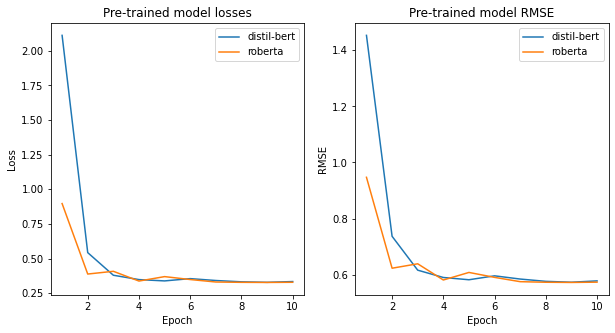

In [ ]:
# Plot losses for both pre trained models
epoch_losses_1, rmse_1 = zip(*performance_stats_distil)
epoch_losses_2, rmse_2 = zip(*performance_stats_roberta)
x = np.arange(epochs) + 1

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(x, epoch_losses_1, label='distil-bert')
plt.plot(x, epoch_losses_2, label='roberta')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pre-trained model losses')

plt.subplot(1, 2, 2)
plt.plot(x, rmse_1, label='distil-bert')
plt.plot(x, rmse_2, label='roberta')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Pre-trained model RMSE')
plt.show()

### Aside: Using NER for Feature Engineering

In [14]:
# Load spacy
ner = spacy.load("en_core_web_sm")

# ps = nltk.stem.porter.PorterStemmer()
# print([ps.stem(word) for word in txt])

# lem = nltk.stem.wordnet.WordNetLemmatizer()
# print([lem.lemmatize(word) for word in txt])

# Test sentences
sents = [
  "#WomensMarch against <Donald Trump/> around the world",
  "' Disappeared ' Lawyer investigating in Egypt the death of Cambridge student , Giulio Regeni , re-appears in court , under <charges/> ",
  "' This is not the end ' : <John McCain/> warns Trump , torches Rand Paul on Syria missile strikes"
]

# Map entities to an index, for representing as 1HV
entities = []

# Build model
for s in sents:
  pre_s = ' '.join([preprocess(t) for t in tokenize(s)])
  r_sub = re.sub(r'[^\w\s]', '', str(s))

  print()
  print(f"Original:       {s}")
  print(f"Preprocessed:   {pre_s}")
  print(f"New regex:      {r_sub}")
  print(f"BERT Tokenized: {tokenizer.tokenize(pre_s)}")

  # NER
  doc = ner(r_sub)
  spacy.displacy.render(doc, style="ent", jupyter=True)

  # TODO: try and merge 'Trump' and 'Donald Trump' for PERSON entities
  for e in doc.ents:
    if e not in entities:
        entities.append(e)

  print()
  
ent2idx = {e: idx for (idx, e) in enumerate(entities)}
print(ent2idx)


Original:       #WomensMarch against <Donald Trump/> around the world
Preprocessed:   womensmarch against donald trump around the world
New regex:      WomensMarch against Donald Trump around the world
BERT Tokenized: ['women', '##sma', '##rch', 'against', 'donald', 'trump', 'around', 'the', 'world']




Original:       ' Disappeared ' Lawyer investigating in Egypt the death of Cambridge student , Giulio Regeni , re-appears in court , under <charges/> 
Preprocessed:   disappeared lawyer investigating in egypt the death of cambridge student giulio regeni re appears in court under charges
New regex:       Disappeared  Lawyer investigating in Egypt the death of Cambridge student  Giulio Regeni  reappears in court  under charges 
BERT Tokenized: ['disappeared', 'lawyer', 'investigating', 'in', 'egypt', 'the', 'death', 'of', 'cambridge', 'student', 'gi', '##ulio', 'reg', '##eni', 're', 'appears', 'in', 'court', 'under', 'charges']




Original:       ' This is not the end ' : <John McCain/> warns Trump , torches Rand Paul on Syria missile strikes
Preprocessed:   this is not the end john mccain warns trump torches rand paul on syria missile strikes
New regex:       This is not the end   John McCain warns Trump  torches Rand Paul on Syria missile strikes
BERT Tokenized: ['this', 'is', 'not', 'the', 'end', 'john', 'mccain', 'warns', 'trump', 'torches', 'rand', 'paul', 'on', 'syria', 'missile', 'strikes']



{Donald Trump: 0, Lawyer: 1, Egypt: 2, Cambridge: 3, Giulio Regeni: 4, John McCain: 5, Trump: 6, Rand Paul: 7, Syria: 8}


## Approach 2
No pre-trained represetations

In [ ]:
class Task1DatasetNN(Dataset):

  def __init__(self, train_data, labels):
    self.x_train = train_data
    self.y_train = labels

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self, item):
    headline = self.x_train[item]
    # processed_headline = ' '.join([preprocess(t) for t in tokenize(headline)])
    processed_headline = [preprocess(t) for t in tokenize(headline)]

    # TODO
    vectorized_headline = processed_headline

    target = self.y_train[item]
    extra_features = extract_features(headline)

    return {
      'encoding': vectorized_headline,
      'target': torch.tensor(target),
      'extra_features': torch.tensor(extra_features)
    }

In [ ]:
# Set training and test data
training_data = train_df['original']
training_labels = train_df['meanGrade']
test_data = test_df['original']
train_and_dev = Task1DatasetNN(training_data, training_labels)

# Split training data into train and dev sets
train_examples = round(len(training_data)*train_proportion)
dev_examples = len(training_data) - train_examples
train_dataset, dev_dataset = random_split(training_data, (train_examples, dev_examples))

In [23]:
# Remove punctuation
def remove_punc(dataset):
  return [re.sub(r'[^\w\s]', '', s) for s in dataset]

# Get NER lookup table from training data
def get_entity2idx(dataset):
  entities = {}
  idx = 0
  for s in dataset:
    doc = ner(s)
    for e in doc.ents:
      e = str(e)
      if e not in entities:
        entities[e] = idx
        idx+=1
  return entities

# Map headlines to list of entity IDs
def get_entity_features(dataset, e2i):
  return [[e2i[str(e)] for e in ner(s).ents] for s in dataset]

# Tokenize, lowercase, remove stop words
def tokenize_no_stopwords(dataset):
  stopwords = nltk.corpus.stopwords.words('english')
  return [[w.lower() for w in s.split(' ') if w not in stopwords and len(w)] for s in dataset]

def tokenize2(dataset):
  return [[w.lower() for w in s.split(' ')] for s in dataset]

# Restrict corpus size for experiments
corpus = remove_punc(train_dataset[:25])
tokenized_corpus = tokenize2(train_dataset)

In [24]:
e2i = get_entity2idx(corpus)
print(e2i)
print(type(e2i['Trump']))
efs = get_entity_features(corpus, e2i)
print(efs[:10])

{'Hawaii': 0, 'Trump': 1, 'Michigan': 2, '3 days': 3, 'Syria': 4, 'HB2 Repeal': 5, 'North Carolina': 6, 'Puerto Rico': 7, '133': 8, 's': 9, 'FEMA': 10, 'Islamists': 11, 'North Korea': 12, 'Africa': 13, 'Nigerian': 14, 'Today': 15, 'Turkey': 16, 'Turkish': 17, 'Erdogan': 18, 'Breitbart News': 19, 'America': 20, 'ESPN': 21, 'Wilbur Ross': 22, 'Saudi Arabia': 23, 'Texas': 24, 'Republican': 25, 'Nikki Haley': 26, 'Michael Wolff': 27, 'California': 28, 'Republicans': 29, 'Trump Vows North Korea': 30, 'first': 31, 'James Comey': 32, 'CIA': 33, 'Flynn': 34, 'Russians': 35, 'The Halfhearted Opposition': 36, 'GOP': 37, 'Maddow': 38, 'Iowa': 39, 'Ronny Jackson': 40, 'Trump s': 41, 'Veterans Affairs': 42}
<class 'int'>
[[0, 1], [1], [2, 3], [4], [], [5, 6], [], [7, 8, 1, 9, 10], [11], []]


In [25]:
class FFNN(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes):  
    super(FFNN, self).__init__()
    
    # embedding (lookup layer) layer
    # padding_idx argument makes sure that the 0-th token in the vocabulary
    # is used for padding purposes i.e. its embedding will be a 0-vector
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
    
    # hidden layer
    self.fc1 = nn.Linear(embedding_dim, hidden_dim)
    
    # activation
    self.relu1 = nn.ReLU()
    
    # output layer
    self.fc2 = nn.Linear(hidden_dim, num_classes)  
  
  # Average sentence embedding (ignoring padding)
  # Maps embedded : (batch_size, max_sent_len, embedding_dim) => (batch_size, embeddind_dim)
  def average_embedding(self, embedded):
    # Want to calculate the avg embedding across all words 
    # This is the max_sent_len dimension so dim=1
    total_emb = torch.sum(embedded, dim=1)

    # Count number of non-zero embeddings to average over
    non_zero_embs = torch.sum(embedded != 0, dim=[1])
    avg_emb = total_emb / non_zero_embs

    return avg_emb

  def forward(self, x):
    # x has shape (batch_size, max_sent_len)
    embedded = self.embedding(x)
    
    # embedding has shape (batch_size, max_sent_len, embedding_dim)
    # Compute the average embeddings of shape (batch_size, embedding_dim) 
    averaged = self.average_embedding(embedded)

    # TODO: extra features

    out = self.fc1(averaged)
    out = self.relu1(out)
    out = self.fc2(out)
    return out

In [26]:
def get_word2idx(tokenized_corpus):
  vocabulary = []
  for sentence in tokenized_corpus:
    for token in sentence:
      if token not in vocabulary:
        vocabulary.append(token)
  word2idx = {w: idx+1 for (idx, w) in enumerate(vocabulary)}
  word2idx['<pad>'] = 0
  return word2idx

def get_model_inputs(tokenized_corpus, word2idx, labels):
  # we index our sentences
  vectorized_sents = [[word2idx[tok] for tok in sent if tok in word2idx] for sent in tokenized_corpus]

  # Sentence lengths
  sent_lengths = [len(sent) for sent in vectorized_sents]

  # Get maximum length
  max_len = max(sent_lengths)
  
  # we create a tensor of a fixed size filled with zeroes for padding
  sent_tensor = torch.zeros((len(vectorized_sents), max_len)).long()

  # we fill it with our vectorized sentences 
  for idx, (sent, sentlen) in enumerate(zip(vectorized_sents, sent_lengths)):
    sent_tensor[idx, :sentlen] = torch.LongTensor(sent)

  # Label tensor
  label_tensor = torch.FloatTensor(labels)
  
  return sent_tensor, label_tensor

# tokenized_corpus = get_tokenized_corpus(train)
word2idx = get_word2idx(tokenized_corpus)
train_sent_tensor, train_label_tensor = get_model_inputs(tokenized_corpus, word2idx, train_labels)

In [31]:
EPOCHS = 10
LRATE = 0.5
EMBEDDING_DIM = 10 # ~4th root of vocab size
HIDDEN_DIM = 50
OUTPUT_DIM = 1

# Construct the model
model = FFNN(EMBEDDING_DIM, HIDDEN_DIM, len(word2idx), OUTPUT_DIM)
print(model)

# we use the stochastic gradient descent (SGD) optimizer
optimizer = optim.SGD(model.parameters(), lr=LRATE)

# we use the binary cross-entropy loss with sigmoid (applied to logits) 
# Recall that we did not apply any activation to our output layer, hence we need
# to make our outputs look like probabilities.
loss_fn = nn.BCEWithLogitsLoss()

# Input and label tensors
feature = train_sent_tensor
target = train_label_tensor

#print(train_dataset[:5])
#print(dev_dataset[:5])

# Start training
for epoch in tqdm(range(1, EPOCHS + 1)):
  # to ensure the dropout (explained later) is "turned on" while training
  # good practice to include even if do not use here
  model.train()
  
  # we zero the gradients as they are not removed automatically
  optimizer.zero_grad()
  
  # squeeze is needed as the predictions will have the shape (batch size, 1)
  # and we need to remove the dimension of size 1
  predictions = model(feature).squeeze(1)

  # Compute the loss
  loss = loss_fn(predictions, target)
  train_loss = loss.item()

  # calculate the gradient of each parameter
  loss.backward()

  # update the parameters using the gradients and optimizer algorithm 
  optimizer.step()
  
  print(f'| Epoch: {epoch:02} | Train Loss: {train_loss:.3f}')

  0%|          | 0/10 [00:00<?, ?it/s]

FFNN(
  (embedding): Embedding(9951, 10, padding_idx=0)
  (fc1): Linear(in_features=10, out_features=50, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)
4049    Hawaii judge rejects Trump administration requ...
2272     <Read/> the full text of Trump 's infrastruct...
731     Michigan <woman/> held captive , sexually assa...
870      <Autopsies/> of victims show chemical weapons...
7489    Disappearing Seagrass Protects Against <Pathog...
Name: original, dtype: object
2821    Bitcoin just tanked below $ 10,000 after SEC s...
2789    Iraqi <forces/> capture 5 top IS leaders in cr...
7243    Why African millennials ca n't <get/> enough o...
4524    Hungary : Protesters rally in defense of <univ...
6372    Kushner , CIM to Get $ 600 Million JPMorgan Lo...
Name: original, dtype: object


NameError: ignored

In [18]:
import collections
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold

count_vec = CountVectorizer()
count_occurs = count_vec.fit_transform([doc])
count_occur_df = pd.DataFrame((count, word) for word, count in zip(count_occurs.toarray().tolist()[0], count_vec.get_feature_names()))
count_occur_df.columns = ['Word', 'Count']
count_occur_df.sort_values('Count', ascending=False, inplace=True)
count_occur_df.head()

AttributeError: ignored

###  No pre-trained representations

In [19]:
# TODO:
# - remove stop words
# - different norms
# - pre: weigh query terms higher for certain

train_and_dev = train_df['edit']

training_data, dev_data, training_y, dev_y = train_test_split(train_df['edit'], train_df['meanGrade'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(training_data)
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)
regression_model = LinearRegression().fit(train_counts, training_y)

# Train predictions
predicted_train = regression_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate model on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = regression_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)


Train performance:
| MSE: 0.13 | RMSE: 0.37 |

Dev performance:
| MSE: 0.36 | RMSE: 0.60 |


#### Baseline for task 2

In [ ]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + np.mean(training_y)
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, dev_y, True)

### Neural Net Classifier Approach
# TODO: need to split this up and use the existing bits we have

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split
import nltk
import torch.optim as optim
from tqdm import tqdm
import re
import pandas as pd
import spacy

!python3 -m spacy download en_core_web_sm
ner = spacy.load("en_core_web_sm")
nltk.download('stopwords')

# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('dev.csv')
train_proportion = 0.8

class Task1DatasetNN(Dataset):

  def __init__(self, train_data, labels, max_len, word2idx, entity2idx, stopwords=nltk.corpus.stopwords.words('english')):
    self.x_train = train_data
    self.y_train = labels
    self.stopwords = stopwords
    self.max_len = max_len
    self.word2idx = word2idx
    self.entity2idx = entity2idx

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self, item):
    headline = self.x_train[item]

    # Remove punctuation
    headline = re.sub(r'[^\w\s]', '', headline)

    # Map headlines to list of entity IDs
    # entities = [self.entity2idx[str(e)] for e in ner(headline).ents if str(e) in self.entity2idx]

    # Tokenize, lowercase, remove stop words
    headline = [w.lower() for w in headline.split() if w not in self.stopwords and len(w)]

    # Get headline vector
    vectorized_headline = [self.word2idx[tok] for tok in headline if tok in self.word2idx]
    headline_tensor = torch.zeros((self.max_len,)).long()
    headline_tensor[:len(vectorized_headline)] = torch.LongTensor(vectorized_headline)

    target_tensor = torch.FloatTensor([self.y_train[item]])
    extra_features = []

    return {
      'encoding': headline_tensor,
      'extra_features': torch.tensor(extra_features),
      'target': target_tensor
    }

#%%

TOKEN_PATTERN = re.compile("\w+")
def tokenize(sentence):
  return TOKEN_PATTERN.findall(sentence)

# Remove angle brackets and lowercase
def preprocess(word):
  if len(word) > 2 and word[0] == '<' and word[-2] == '/' and word[-1] == '>' :
    word = word[1:-2]
  return word.lower()

# Create vocab of all words
def create_vocab(data):
  # Let us put the tokenized corpus in a list
  tokenized_corpus = [[preprocess(t) for t in tokenize(s)] for s in data]

  # Create single list of all vocabulary
  vocabulary = []
  for sentence in tokenized_corpus:
    for token in sentence:
      if token not in vocabulary:
        vocabulary.append(token)

  return vocabulary, tokenized_corpus

# TODO: need to tie this in with NER
def build_word2idx(tokenized_corpus):
  vocabulary = []
  for sentence in tokenized_corpus:
    for token in sentence:
      if token not in vocabulary:
        vocabulary.append(token)
  w2i = {w: idx+1 for (idx, w) in enumerate(vocabulary)}
  w2i['<pad>'] = 0
  return w2i

# Get NER lookup table from training data
def build_entity2idx(corpus):
  entities = {}
  idx = 0
  for s in corpus:
    doc = ner(s)
    for e in doc.ents:
      e = str(e)
      if e not in entities:
        entities[e] = idx
        idx+=1
  return entities

#%%

# e2i = get_entity2idx(corpus)
# print(e2i)
# print(type(e2i['Trump']))
# efs = get_entity_features(corpus, e2i)
# print(efs[:10])

#%%

class FFNN(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes):
    super(FFNN, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
    self.fc1 = nn.Linear(embedding_dim, hidden_dim)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(hidden_dim, num_classes)
    self.relu2 = nn.ReLU()

  # Average sentence embedding (ignoring padding)
  # Maps embedded : (batch_size, max_sent_len, embedding_dim) => (batch_size, embeddind_dim)
  def average_embedding(self, embedded):
    # Want to calculate the avg embedding across all words
    # This is the max_sent_len dimension so dim=1
    total_emb = torch.sum(embedded, dim=1)

    # Count number of non-zero embeddings to average over
    non_zero_embs = torch.sum(embedded != 0, dim=[1])
    avg_emb = total_emb / non_zero_embs

    return avg_emb

  def forward(self, x):
    # x has shape (batch_size, max_sent_len)
    embedded = self.embedding(x)

    # embedding has shape (batch_size, max_sent_len, embedding_dim)
    # Compute the average embeddings of shape (batch_size, embedding_dim)
    averaged = self.average_embedding(embedded)

    # TODO: extra features

    out = self.fc1(averaged)
    out = self.relu1(out)
    out = self.fc2(out)
    # out = self.relu2(out)
    return out


#%%

EPOCHS = 10
LRATE = 0.1
EMBEDDING_DIM = 20 # ~4th root of vocab size
HIDDEN_DIM = 50
OUTPUT_DIM = 1

# Set training and test data
training_data = train_df['original']
training_labels = train_df['meanGrade']
test_data = test_df['original']

_vocab, tokenized_corpus = create_vocab(training_data)
max_headline_len = max([len([w for w in s.split()]) for s in training_data])
w2i = build_word2idx(tokenized_corpus)
# e2i = build_entity2idx(training_data)
e2i = {}

train_and_dev = Task1DatasetNN(training_data, training_labels, max_headline_len, w2i, e2i)

# TODO: what processing should be done on both train and dev and what should be done on just train???
# Split training data into train and dev sets
train_examples = round(len(training_data)*train_proportion)
dev_examples = len(training_data) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev, (train_examples, dev_examples))

# train_sent_tensor, train_label_tensor
i2w = {v:k for k,v in w2i.items()}

# for a, d in zip(training_data, train_and_dev):
#   d = d['encoding'].tolist()
#   dec = [i2w[i] for i in d]
#   print(a)
#   print(dec)


#%%

# Create data loaders
BATCH_SIZE = 50
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE)

# Construct the model
model = FFNN(EMBEDDING_DIM, HIDDEN_DIM, len(w2i), OUTPUT_DIM)
print(model)

# we use the stochastic gradient descent (SGD) optimizer
optimizer = optim.SGD(model.parameters(), lr=LRATE)

# we use the binary cross-entropy loss with sigmoid (applied to logits)
# Recall that we did not apply any activation to our output layer, hence we need
# to make our outputs look like probabilities.
loss_fn = nn.MSELoss()

# Start training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 10
for epoch in range(EPOCHS):
  # to ensure the dropout (explained later) is "turned on" while training
  # good practice to include even if do not use here
  model.train()

  for batch in train_loader:

    encoding = batch['encoding'].to(device)
    target = batch['target'].to(device).squeeze(1)
    # extra_features = batch['extra_features'].to(device)

    # we zero the gradients as they are not removed automatically
    optimizer.zero_grad()

    # squeeze is needed as the predictions will have the shape (batch size, 1)
    # and we need to remove the dimension of size 1
    predictions = model(encoding).squeeze(1)

    # Compute the loss
    loss = loss_fn(predictions, target)
    train_loss = loss.item()

    # calculate the gradient of each parameter
    loss.backward()

    # update the parameters using the gradients and optimizer algorithm
    optimizer.step()

  print(f'| Epoch: {epoch:02} | Train Loss: {train_loss:.3f}')
#%%

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
FFNN(
  (embedding): Embedding(7265, 20, padding_idx=0)
  (fc1): Linear(in_features=20, out_features=50, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
  (relu2): ReLU()
)
| Epoch: 00 | Train Loss: 0.278
| Epoch: 01 | Train Loss: 0.342
| Epoch: 02 | Train Loss: 0.326
| Epoch: 03 | Train Loss: 0.467
| Epoch: 04 | Train Loss: 0.282
| Epoch: 05 | Train Loss: 0.299
| Epoch: 06 | Train Loss: 0.481
| Epoch: 07 | Train Loss: 0.469
| Epoch: 08 | Train Loss: 0.358
| Epoch: 09 | Train Loss: 0.226
